In [2]:
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from keras import layers
from keras.applications import DenseNet121, ResNet50V2, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import Constant
from keras.utils import Sequence
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2
import keras.metrics as M
import tensorflow_addons as tfa
import pickle
from keras import backend as K
import tensorflow as tf
from tensorflow.python.ops import array_ops
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings
warnings.filterwarnings(action='once')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.optimizers import RMSprop,Adam,Optimizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.applications import xception
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
# Folders
BASE_PATH = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'
# Setting the path and Reading the data
train = pd.read_csv("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv")
sub = pd.read_csv("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv")
train_images = os.listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/")
test_images = os.listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/")
print ('Train:', train.shape[0])
print ('Sub:', sub.shape[0])

Train: 4516842
Sub: 727392


In [4]:
# Getting training and testing data
train['type'] = train['ID'].str.split("_", n = 3, expand = True)[2]
train['PatientID'] = train['ID'].str.split("_", n = 3, expand = True)[1]
train['filename'] = train['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
# Remove invalid PNGs
train=train.head(500000)


sub['filename'] = sub['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
sub['type'] = sub['ID'].apply(lambda st: st.split('_')[2])
sub=sub.head(110000)
train.head()

,ID,Label,type,PatientID,filename
0,ID_12cadc6af_epidural,0,epidural,12cadc6af,ID_12cadc6af.png
1,ID_12cadc6af_intraparenchymal,0,intraparenchymal,12cadc6af,ID_12cadc6af.png
2,ID_12cadc6af_intraventricular,0,intraventricular,12cadc6af,ID_12cadc6af.png
3,ID_12cadc6af_subarachnoid,0,subarachnoid,12cadc6af,ID_12cadc6af.png
4,ID_12cadc6af_subdural,0,subdural,12cadc6af,ID_12cadc6af.png


In [5]:
# Understanding the unique types of brain hemmorhage
print ('Train type =', list(train.type.unique()))
print ('Train label =', list(train.Label.unique()))

Train type = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
Train label = [0, 1]


In [6]:
# No of unique type of patients for each of the category
print ('Number of Patients: ', train.PatientID.nunique())

Number of Patients:  83333


In [7]:
# No of unique type of patients for each of the category
train.type.value_counts()

intraparenchymal    83334
epidural            83334
subdural            83333
any                 83333
intraventricular    83333
subarachnoid        83333
Name: type, dtype: int64

0    471423
1     28577
Name: Label, dtype: int64


<AxesSubplot:xlabel='Label', ylabel='count'>

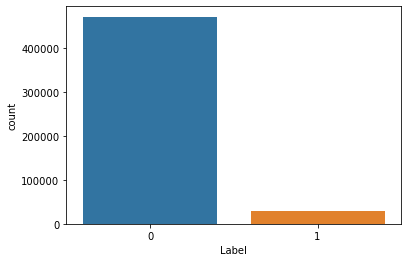

In [8]:
# Images with label of 0 and 1 such as hammerhoage or not
print(train.Label.value_counts())
sns.countplot(x='Label', data=train)

In [9]:
# Understanding the no of unique type of patients for each of the category in 0 and 1
train.groupby('type').Label.value_counts()

type              Label
any               0        71321
                  1        12012
epidural          0        82960
                  1          374
intraparenchymal  0        79257
                  1         4077
intraventricular  0        80438
                  1         2895
subarachnoid      0        79322
                  1         4011
subdural          0        78125
                  1         5208
Name: Label, dtype: int64

<AxesSubplot:xlabel='Label', ylabel='count'>

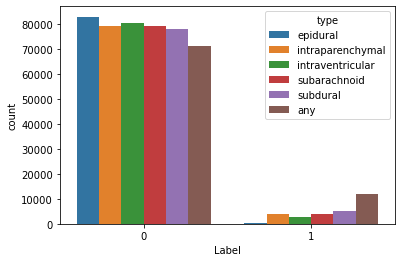

In [10]:
# Understanding the no of unique type of patients for each of the category in 0 and 1
# in terms of barplot
sns.countplot(x="Label", hue="type", data=train)

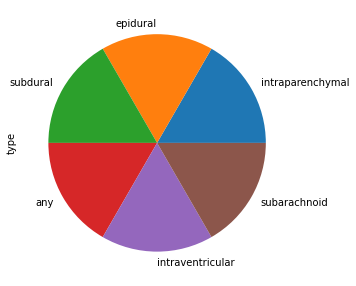

In [11]:
# Understanding the no of unique type of patients for each of the category in 0 and 1
# in terms of Pie-plot
train.type.value_counts().plot.pie(figsize=(5,5))
plt.show()

In [12]:
# Here, we are setting the image' windows (3types), ROI and skull removal  
TRAIN_IMG_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/"
TEST_IMG_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/"
BASE_PATH = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'

def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

    
    
def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        data = pydicom.read_file(os.path.join(TRAIN_IMG_PATH,'ID_'+images[im]+ '.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
    plt.suptitle(title)
    plt.show()

data Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.4267.32.125846227819956469853355733412611275406
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_4b08fe185
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_6338c4f1'
(0020, 000d) Study Instance UID                  UI: ID_a3b607ba3f
(0020, 000e) Series Instance UID                 UI: ID_468e9dedde
(0020, 0010) Study ID                            

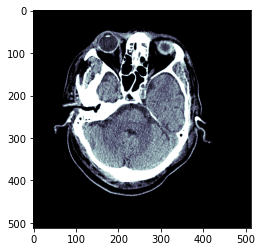

In [13]:
# Demonstration of single image and its complete meta-data information
import pydicom
case = 8
data = pydicom.dcmread(TRAIN_IMG_PATH+train_images[case])

print("data",data)
window_center , window_width, intercept, slope = get_windowing(data)


#displaying the image
img = pydicom.read_file(TRAIN_IMG_PATH+train_images[case]).pixel_array

img = window_image(img, window_center, window_width, intercept, slope)
plt.imshow(img, cmap=plt.cm.bone)
plt.grid(False)

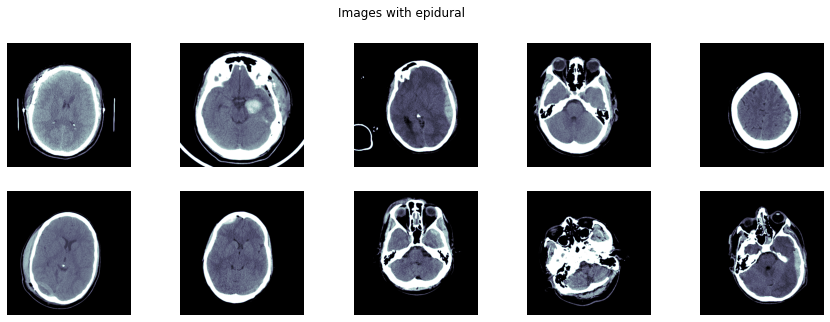

In [14]:
# Demonstration of some epidural images with label 1
view_images(train[(train['type'] == 'epidural') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with epidural')

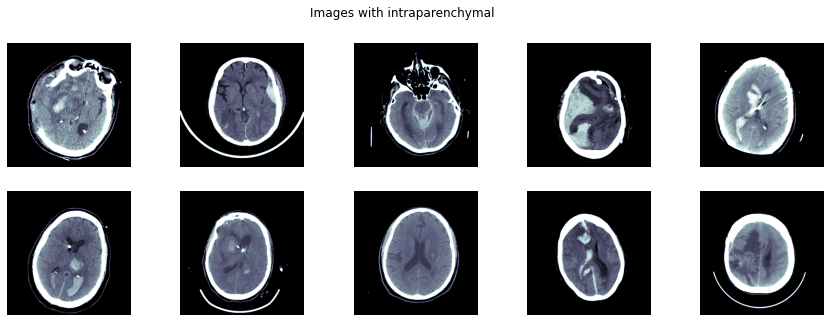

In [15]:
# Demonstration of some intraparenchymal images with label 1
view_images(train[(train['type'] == 'intraparenchymal') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with intraparenchymal')

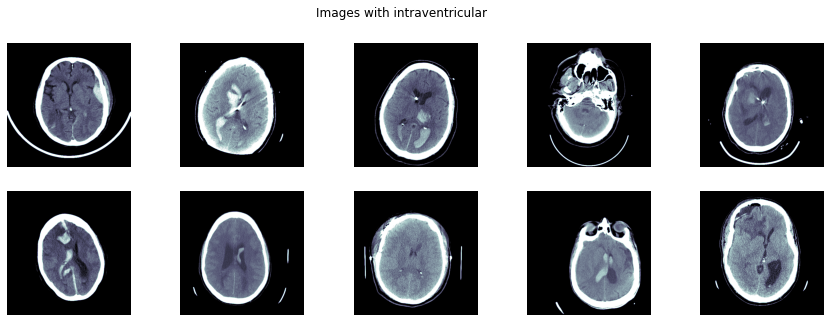

In [16]:
# Demonstration of some intraparenchymal images with label 1
view_images(train[(train['type'] == 'intraventricular') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with intraventricular')

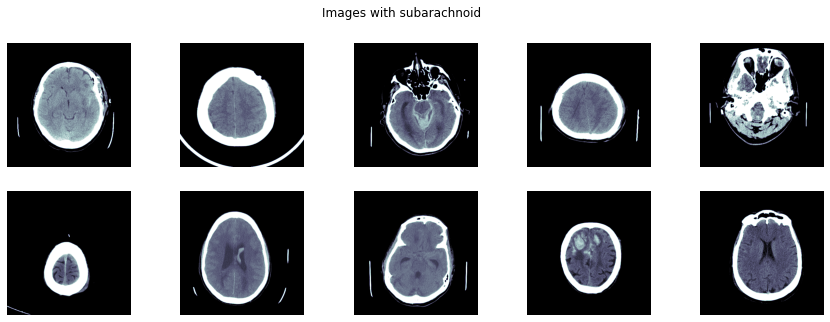

In [17]:
# Demonstration of some subarachnoid images with label 1
view_images(train[(train['type'] == 'subarachnoid') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with subarachnoid')

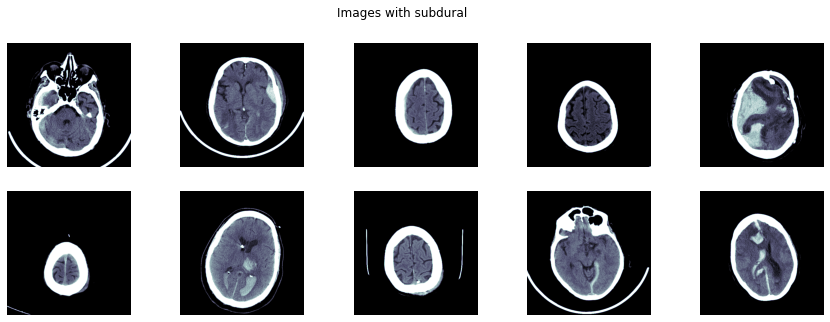

In [18]:
# Demonstration of some subdural images with label 1
view_images(train[(train['type'] == 'subdural') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with subdural')

In [19]:
# Setting and demonstration of testing data
test = pd.DataFrame(sub.filename.unique(), columns=['filename'])
print ('Test:', test.shape[0])
test.head()

Test: 18334


,filename
0,ID_0fbf6a978.png
1,ID_d62ec3412.png
2,ID_cb544194b.png
3,ID_0d62513ec.png
4,ID_fc45b2151.png


In [20]:
# Getting some random images for training and testing to reduce the computational complexity
np.random.seed(1234)
sample_files = np.random.choice(os.listdir(TRAIN_IMG_PATH),15000)
sample_df = train[train.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_files)]
print(sample_df.shape)

pivot_df = sample_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_df.shape)
pivot_df.head()

(10200, 5)
(1700, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_002287eb9.png,1,0,0,0,1,0
1,ID_002df9e35.png,0,0,0,0,0,0
2,ID_007451ba1.png,0,0,0,0,0,0
3,ID_008ce33f8.png,0,0,0,0,0,0
4,ID_00aadf5ae.png,1,0,0,0,0,1


In [21]:
# Getting some random images for training and testing to reduce the computational complexity
np.random.seed(1234)
test_sample_files = np.random.choice(os.listdir(TEST_IMG_PATH),10000)
test_sample_df = sub[sub.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(test_sample_files)]
print(test_sample_df.shape)

test_pivot_df = test_sample_df[['Label', 'filename', 'ID']].drop_duplicates().pivot(
    index='filename', columns='ID', values='Label').reset_index()
print(test_pivot_df.shape)
test_pivot_df.head()

(8568, 4)
(1428, 8569)


ID,filename,ID_00235d45f_any,ID_00235d45f_epidural,ID_00235d45f_intraparenchymal,ID_00235d45f_intraventricular,ID_00235d45f_subarachnoid,ID_00235d45f_subdural,ID_007940f41_any,ID_007940f41_epidural,ID_007940f41_intraparenchymal,...,ID_ff01307ec_intraparenchymal,ID_ff01307ec_intraventricular,ID_ff01307ec_subarachnoid,ID_ff01307ec_subdural,ID_ff176263c_any,ID_ff176263c_epidural,ID_ff176263c_intraparenchymal,ID_ff176263c_intraventricular,ID_ff176263c_subarachnoid,ID_ff176263c_subdural
0,ID_00235d45f.png,0.5,0.5,0.5,0.5,0.5,0.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_007940f41.png,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID_00b2c9c46.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_00c89f0e9.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID_00ed98dbe.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
train_df = pd.read_csv(BASE_PATH + 'stage_2_train.csv')
#sub_df = pd.read_csv(BASE_PATH + 'stage_1_sample_submission.csv')

train_df['id'] = train_df['ID'].apply(lambda st: "ID_" + st.split('_')[1])
train_df['subtype'] = train_df['ID'].apply(lambda st: st.split('_')[2])
#sub_df['filename'] = sub_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
#sub_df['type'] = sub_df['ID'].apply(lambda st: st.split('_')[2])

print(train_df.shape)
train_df.head()

(4516842, 4)


,ID,Label,id,subtype
0,ID_12cadc6af_epidural,0,ID_12cadc6af,epidural
1,ID_12cadc6af_intraparenchymal,0,ID_12cadc6af,intraparenchymal
2,ID_12cadc6af_intraventricular,0,ID_12cadc6af,intraventricular
3,ID_12cadc6af_subarachnoid,0,ID_12cadc6af,subarachnoid
4,ID_12cadc6af_subdural,0,ID_12cadc6af,subdural


In [23]:
train_df = train_df[["id","subtype","Label"]]
train_df.head()

,id,subtype,Label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [24]:
train_df = pd.pivot_table(train_df,index="id",columns="subtype",values="Label")
train_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0


In [25]:
pivot_df = train_df.copy()
#bad = []
#for index,row in tqdm(pivot_df.iterrows()):
#    f = BASE_PATH+TRAIN_DIR+index+".dcm"
#    dcm = pydicom.dcmread(f)
#    try:
#        d = dcm.pixel_array
#    except:
#        bad.append(index)
pivot_df.drop("ID_6431af929",inplace=True)
#print(bad)

In [26]:
def map_to_gradient(grey_img):
    rainbow_img = np.zeros((grey_img.shape[0], grey_img.shape[1], 3))
    rainbow_img[:, :, 0] = np.clip(4 * grey_img - 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    rainbow_img[:, :, 1] =  np.clip(4 * grey_img * (grey_img <=0.75), 0,1) + np.clip((-4*grey_img + 4) * (grey_img > 0.75), 0, 1)
    rainbow_img[:, :, 2] = np.clip(-4 * grey_img + 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    return rainbow_img

def rainbow_window(dcm):
    grey_img = window_image(dcm, 40, 80)
    return map_to_gradient(grey_img)

import cupy as cp

def sigmoid_window(dcm, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):
    img = dcm.pixel_array
    img = cp.array(np.array(img))
    _, _, intercept, slope = get_windowing(dcm)
    img = img * slope + intercept
    ue = cp.log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + cp.power(np.e, -1.0 * z))
    img = (img - cp.min(img)) / (cp.max(img) - cp.min(img))
    return cp.asnumpy(img)

def sigmoid_bsb_window(dcm):
    brain_img = sigmoid_window(dcm, 40, 80)
    subdural_img = sigmoid_window(dcm, 80, 200)
    bone_img = sigmoid_window(dcm, 600, 2000)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img

def window_image(dcm, window_center, window_width):
    _, _, intercept, slope = get_windowing(dcm)
    img = dcm.pixel_array * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    bone_img = window_image(dcm, 600, 2000)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

/opt/conda/lib/python3.7/site-packages/cupy/_environment.py:265: ResourceWarning: unclosed file <_io.TextIOWrapper name='/opt/conda/lib/python3.7/site-packages/cupy/.data/_wheel.json' mode='r' encoding='UTF-8'>
  _preload_config = json.load(open(config_path))
/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [27]:
def preprocess(file,type="WINDOW"):
    dcm = pydicom.dcmread(BASE_PATH+TRAIN_DIR+file+".dcm")
    if type == "WINDOW":
        window_center , window_width, intercept, slope = get_windowing(dcm)
        w = window_image(dcm, window_center, window_width)
        win_img = np.repeat(w[:, :, np.newaxis], 3, axis=2)
        #return win_img
    elif type == "SIGMOID":
        window_center , window_width, intercept, slope = get_windowing(dcm)
        test_img = dcm.pixel_array
        w = sigmoid_window(dcm, window_center, window_width)
        win_img = np.repeat(w[:, :, np.newaxis], 3, axis=2)
        #return win_img
    elif type == "BSB":
        win_img = bsb_window(dcm)
        #return win_img
    elif type == "SIGMOID_BSB":
        win_img = sigmoid_bsb_window(dcm)
    elif type == "GRADIENT":
        win_img = rainbow_window(dcm)
        #return win_img
    else:
        win_img = dcm.pixel_array
    resized = cv2.resize(win_img,(224,224))
    return resized

In [28]:
class DataLoader(Sequence):
    def __init__(self, dataframe,
                 batch_size,
                 shuffle,
                 input_shape,
                 num_classes=6,
                 steps=None,
                 prep="BSB"):
        
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.current_epoch=0
        self.prep = prep
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3
            self.undersample()
        
    def undersample(self):
        part = np.int(self.steps/3 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=5000, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=5000, replace=True)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)
        
    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 3*np.int(self.steps/3) 
    
    # at the end of an epoch: 
    def on_epoch_end(self):
        # if steps is None and shuffle is true:
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, item):
        # select the ids of the current batch
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y = self.__generate_batch(current_ids)
        return X, y
    
    # collect the preprocessed images and targets of one batch
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y = np.empty((self.batch_size, self.num_classes))
        for idx, ident in enumerate(current_ids):
            # Store sample
            #image = self.preprocessor.preprocess(ident) 
            image = preprocess(ident,self.prep)
            X[idx] = image
            # Store class
            y[idx] = self.__get_target(ident)
        return X, y
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        targets = self.dataframe.loc[ident].values
        return targets

In [29]:
def DenseNet():
    densenet = DenseNet121(
    #weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    weights='imagenet',
    include_top=False)
    return densenet
def ResNet():
    resnet = ResNet50V2(weights="imagenet",include_top=False)
    return resnet
def Inception():
    incept = InceptionV3(weights="imagenet",include_top=False)
    return incept

def get_backbone(name):
    if name == "RESNET":
        return ResNet
    elif name == "DENSE":
        return DenseNet
    elif name == "INCEPT":
        return Inception

def build_model(backbone):
    m = backbone()
    x = m.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.3)(x)
    pred = Dense(6,activation="sigmoid")(x)
    model = Model(inputs=m.input,outputs=pred)
    return model

In [30]:
# model = build_model(get_backbone("DENSE"))
# model.summary()

In [31]:
# model = build_model(get_backbone("RESNET"))
# model.summary()

In [32]:
# model = build_model(get_backbone("INCEPT"))
# model.summary()

In [33]:
train,test = train_test_split(pivot_df,test_size=0.2,random_state=42,shuffle=True)

split_seed = 1
kfold = StratifiedKFold(n_splits=5, random_state=split_seed,shuffle=True).split(np.arange(train.shape[0]), train["any"].values)

train_idx, dev_idx = next(kfold)

#Images Classes with index
train_data = train.iloc[train_idx]
dev_data = train.iloc[dev_idx]

#train_data, dev_data = train_test_split(traindf, test_size=0.1, stratify=traindf.values, random_state=split_seed)
print(train_data.shape)
print(dev_data.shape)

(481792, 6)
(120449, 6)


In [34]:
# #     def inner_casting(y_true,y_pred):
# #         y_true = tf.cast(y_true, tf.float32)
# #         y_pred = tf.cast(y_pred, tf.float32)
# #         return tfa.losses.SigmoidFocalCrossEntropy(y_true,y_pred)
    

# METRICS = ['accuracy','Precision','Recall','AUC']
# #LOSS = casting_focal_loss()
# #LOSS = 'categorical_crossentropy'
# LOSS='binary_crossentropy'

# BATCH_SIZE =32
# TRAIN_STEPS = 200#(train_data.shape[0] // BATCH_SIZE)
# VAL_STEPS = 200#dev_data.shape[0] // BATCH_SIZE
# EPOCHS = 15

# ALPHA = 0.5
# GAMMA = 2

# LR = 0.0001

# PREP = "SIGMOID_BSB"
# #for ARCH in ['RESNET','DENSE','INCEPT']:# Set Data Generator for training, testing and validataion.

# # Note for testing, set shuffle = false (For proper Confusion matrix)

# # Set Data Generator for training, testing and validataion.

# # Note for testing, set shuffle = false (For proper Confusion matrix)

# train_dataloader = DataLoader(train_data,
#                               BATCH_SIZE,
#                               shuffle=True,
#                               input_shape=(224,224),
#                               steps=TRAIN_STEPS,
#                               prep=PREP)

# dev_dataloader = DataLoader(dev_data, 
#                             BATCH_SIZE,
#                             shuffle=True,
#                             input_shape=(224,224),
#                             steps=VAL_STEPS,
#                             prep=PREP)

# test_dataloader = DataLoader(test,
#                              BATCH_SIZE,
#                              shuffle=False,
#                              input_shape=(224,224),
#                              prep=PREP)


    
# cpath = "./" + 'INCEPT' + "_" + PREP + "_" + str(TRAIN_STEPS) + "_" + str(EPOCHS) 

# checkpoint = ModelCheckpoint(filepath=cpath + ".model",mode="min",verbose=1,save_best_only=True,save_weights_only=False,period=1)

# model = build_model(get_backbone('INCEPT'))

# #compile the model
# model.compile(optimizer=Adam(learning_rate=LR),loss=LOSS,metrics=[METRICS,tfa.metrics.F1Score(num_classes=6, average="micro")])

# #Train the model
# history = model.fit_generator(generator=train_dataloader,validation_data=dev_dataloader,epochs=EPOCHS,workers=8,callbacks=[checkpoint])

# with open(cpath + ".history", 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)


In [35]:
import pickle
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a custom loss function if needed
# def inner_casting(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)
#     return tfa.losses.SigmoidFocalCrossEntropy(y_true, y_pred)

METRICS = ['accuracy', 'Precision', 'Recall', 'AUC']

# Define the loss function
LOSS = 'binary_crossentropy'

BATCH_SIZE = 32
TRAIN_STEPS = 200  # You can adjust this based on your data size
VAL_STEPS = 200    # You can adjust this based on your data size
EPOCHS = 15

ALPHA = 0.5
GAMMA = 2

LR = 0.0001

PREP = "SIGMOID_BSB"

# Loop through different architectures (e.g., 'RESNET', 'DENSE', 'INCEPT')
for ARCH in ['RESNET', 'DENSE', 'INCEPT']:
    print(f"Training for architecture {ARCH}...")

    # Set Data Generator for training, testing, and validation
    train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True, input_shape=(224, 224), steps=TRAIN_STEPS, prep=PREP)
    dev_dataloader = DataLoader(dev_data, BATCH_SIZE, shuffle=True, input_shape=(224, 224), steps=VAL_STEPS, prep=PREP)
    test_dataloader = DataLoader(test, BATCH_SIZE, shuffle=False, input_shape=(224, 224), prep=PREP)

    cpath = "./" + ARCH + "_" + PREP + "_" + str(TRAIN_STEPS) + "_" + str(EPOCHS)

    checkpoint = ModelCheckpoint(filepath=cpath + ".model", mode="min", verbose=1, save_best_only=True, save_weights_only=False, period=1)

    model = build_model(get_backbone(ARCH))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=LR), loss=LOSS, metrics=[METRICS, tfa.metrics.F1Score(num_classes=6, average="micro")])

    # Train the model
    history = model.fit_generator(generator=train_dataloader, validation_data=dev_dataloader, epochs=EPOCHS, workers=8, callbacks=[checkpoint])

    with open(cpath + ".history", 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


Training for architecture RESNET...
94674944/94668760 [==============================] - 4s 0us/step
Epoch 1/15
201/201 [==============================] - 180s 838ms/step - loss: 0.4432 - accuracy: 0.6348 - precision: 0.4892 - recall: 0.3636 - auc: 0.7582 - f1_score: 0.3701 - val_loss: 0.3067 - val_accuracy: 0.9291 - val_precision: 0.6707 - val_recall: 0.6047 - val_auc: 0.8918 - val_f1_score: 0.4404

Epoch 00001: val_loss improved from inf to 0.30667, saving model to ./RESNET_SIGMOID_BSB_200_15.model
Epoch 2/15
201/201 [==============================] - 169s 833ms/step - loss: 0.3109 - accuracy: 0.7510 - precision: 0.7158 - recall: 0.5471 - auc: 0.8859 - f1_score: 0.4374 - val_loss: 0.2608 - val_accuracy: 0.9633 - val_precision: 0.8027 - val_recall: 0.5753 - val_auc: 0.9181 - val_f1_score: 0.4438

Epoch 00002: val_loss improved from 0.30667 to 0.26076, saving model to ./RESNET_SIGMOID_BSB_200_15.model
Epoch 3/15
201/201 [==============================] - 169s 832ms/step - loss: 0.2894 

In [ ]:
plt.plot(history.epoch, history.history["loss"])

In [36]:
# Create dictionaries to store evaluation results for each architecture
results = {'RESNET': None, 'DENSE': None, 'INCEPT': None}

# Loop through different architectures
for ARCH in ['RESNET', 'DENSE', 'INCEPT']:
    print(f"Evaluating architecture {ARCH}...")

    # Load the trained model
    model = tf.keras.models.load_model(f'./{ARCH}_{PREP}_{TRAIN_STEPS}_{EPOCHS}.model')

    # Evaluate the model on the test data
    test_results = model.evaluate(test_dataloader)

    # Store the evaluation results in the dictionary
    results[ARCH] = test_results

# Print the results summary
for ARCH, test_results in results.items():
    print(f"Architecture: {ARCH}")
    print("Test loss:", test_results[0])
    print("Test accuracy:", test_results[1])
    print("Test Precision:", test_results[2])
    print("Test Recall:", test_results[3])
    print("Test AUC:", test_results[4])
    print("Test F1 Score (micro):", test_results[5])
    print()

# Determine the best-performing architecture based on accuracy
best_architecture = max(results, key=lambda arch: results[arch][1])
print(f"The best-performing architecture is: {best_architecture}")


Evaluating architecture RESNET...
4706/4706 [==============================] - 4308s 915ms/step - loss: inf - accuracy: 0.9607 - precision: 0.6772 - recall: 0.7076 - auc: 0.9649 - f1_score: nan
Evaluating architecture DENSE...
4706/4706 [==============================] - 3643s 774ms/step - loss: 0.1106 - accuracy: 0.8793 - precision: 0.6390 - recall: 0.7357 - auc: 0.9632 - f1_score: 0.2139
Evaluating architecture INCEPT...
4706/4706 [==============================] - 3654s 776ms/step - loss: 0.1119 - accuracy: 0.8959 - precision: 0.6090 - recall: 0.7684 - auc: 0.9672 - f1_score: 0.2142
Architecture: RESNET
Test loss: inf
Test accuracy: 0.9606951475143433
Test Precision: 0.6772169470787048
Test Recall: 0.7075827717781067
Test AUC: 0.9649196267127991
Test F1 Score (micro): nan

Architecture: DENSE
Test loss: 0.11061366647481918
Test accuracy: 0.8793428540229797
Test Precision: 0.6389888525009155
Test Recall: 0.7357341647148132
Test AUC: 0.9631800651550293
Test F1 Score (micro): 0.2138907

In [ ]:
# Evaluate the model on the test data
test_results = model.evaluate(test_dataloader, verbose=0)

loss, accuracy, precision, recall, auc, f1_score = test_results

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test AUC: {auc:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")


In [ ]:
import numpy as np
# Print a summary of the results
for epoch in range(EPOCHS):
    training_loss = history.history['loss'][epoch]
    training_accuracy = history.history['accuracy'][epoch]
    training_precision = history.history['precision'][epoch]
    training_recall = history.history['recall'][epoch]
    training_auc = history.history['auc'][epoch]
    training_f1_score = history.history['f1_score'][epoch]

    validation_loss = history.history['val_loss'][epoch]
    validation_accuracy = history.history['val_accuracy'][epoch]
    validation_precision = history.history['val_precision'][epoch]
    validation_recall = history.history['val_recall'][epoch]
    validation_auc = history.history['val_auc'][epoch]
    validation_f1_score = history.history['val_f1_score'][epoch]

    summary = f"{epoch+1} of {EPOCHS} epoch output example: "
    summary += f"{training_loss:.4f} - accuracy: {training_accuracy:.4f} "
    summary += f"- precision: {training_precision:.4f} - recall: {training_recall:.4f} "
    summary += f"- auc: {training_auc:.4f} - f1_score: {training_f1_score:.4f} "
    summary += f"- val_loss: {validation_loss:.4f} - val_accuracy: {validation_accuracy:.4f} "
    summary += f"- val_precision: {validation_precision:.4f} - val_recall: {validation_recall:.4f} "
    summary += f"- val_auc: {validation_auc:.4f} - val_f1_score: {validation_f1_score:.4f}"

    print(summary)


In [ ]:
print("Evaluate")
test_prob = model.evaluate(test_dataloader,steps=400)
res = dict(zip(model.metrics_names, test_prob))
print(res)

In [ ]:
#predicting on test data.
    
print("Predict")
Y_pred =model.predict_generator(test_dataloader.classes)
y_pred = np.argmax(Y_pred, axis=1)# get the class with highest probability for each sample
y_pred= dict(zip(model.metrics_names, y_pred))
print(y_pred)

In [ ]:
#Get the accuracy score

test_score = model.evaluate_generator(test_dataloader,32)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 

print("[INFO] Loss: ",test_score[0])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
#Confution Matrix 
print('Confusion Matrix')
print(confusion_matrix(test_dataloader,pred_test))


In [ ]:
print('Classification Report')
print(classification_report(test_dataloader, y_pred))


In [ ]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()